# Improve AutoEncoder

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(512)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Getting the data ready

In [3]:
train_dir = '/Users/lzhan/Downloads/imaterialist-fashion-2019-FGVC6/'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(directory=train_dir,
                        batch_size=32,
                        target_size=(64,64),
                        class_mode='binary',
                        color_mode='rgb',
                        seed=42)

Found 51170 images belonging to 3 classes.


In [5]:
x_train = []
for i in range(len(train_data)):
    batch = train_data[i][0]
    x_train.append(batch)
x_train = np.concatenate(x_train, axis=0)

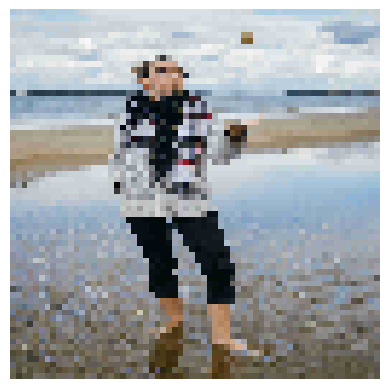

In [6]:
# Randomly plot an image
import matplotlib.pyplot as plt
random_idx = np.random.randint(0, 100)
plt.imshow(x_train[random_idx])
plt.axis('off')
plt.show()

## Create VAE

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    return Model(input_layer, [z_mean, z_log_var, z])

def build_decoder(latent_dim, output_shape):
    input_layer = Input(shape=(latent_dim,))

    x = Dense(16 * 16 * 64, activation='relu')(input_layer)
    x = Reshape((16, 16, 64))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    output_layer = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_layer, output_layer)

def build_vae(encoder, decoder):
    input_shape = encoder.input_shape[1:]
    latent_dim = encoder.output_shape[-1]

    inputs = Input(shape=input_shape)
    z_mean, z_log_var, z = encoder(inputs)
    outputs = decoder(z)
    vae = Model(inputs, outputs)
    
    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae

In [8]:
latent_dim = 200
image_shape = (64, 64, 3)

encoder = build_encoder(image_shape, latent_dim)
decoder = build_decoder(latent_dim, image_shape)

vae = build_vae(encoder, decoder)
vae.compile(optimizer=Adam(lr=0.000001))
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model (Functional)             [(None, 200),        288352      ['input_3[0][0]']                
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                                  
 model_1 (Functional)           (None, 64, 64, 3)    3349443     ['model[0][2]']                  
                                                                                            

C:\Users\lzhan\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
epochs = 3000
batch_size = 32

# Train the VAE
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/3000
1600/1600 [==============================] - 13s 7ms/step - loss: 8513.7441
Epoch 2/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8510.2617
Epoch 3/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8507.6240
Epoch 4/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8506.1572
Epoch 5/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8505.5117
Epoch 6/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8505.2197
Epoch 7/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8504.9990
Epoch 8/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8504.7832
Epoch 9/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8504.4521
Epoch 10/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8503.9844
Epoch 11/3000
1600/1600 [==============================] - 11s 7ms/step - loss: 8502.8779
Epoch 12/3000
1600/

In [10]:
def display(array1, array2, n=10):
    indices = np.random.randint(len(array2), size=n)  # Generate random indices based on the length of array2
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

4/4 [==============================] - 0s 3ms/step


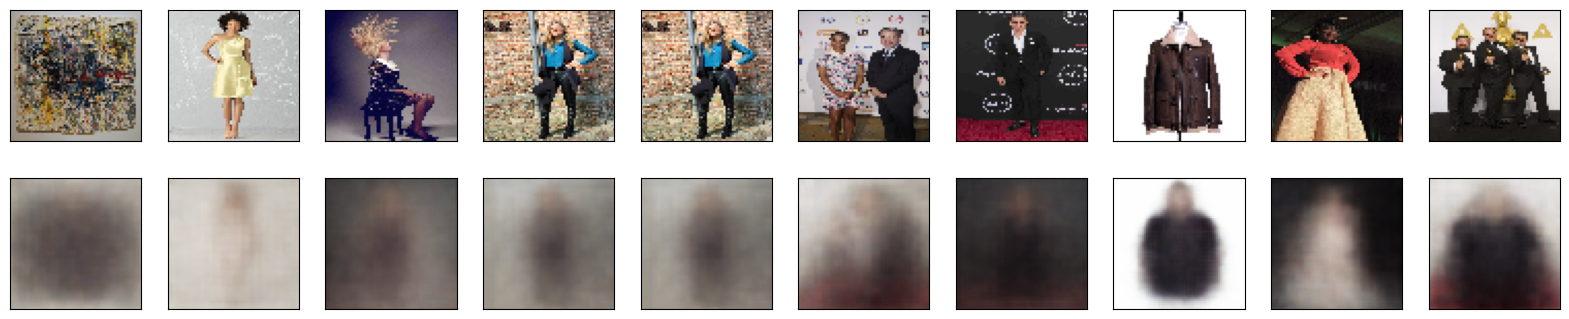

In [14]:
predictions = vae.predict(x_train[:100])
display(x_train, predictions)